In [ ]:
from google.colab import files
import zipfile
import os

# Step 1: Upload the ZIP file to Colab
print("Please upload your ZIP file...")
uploaded = files.upload()

# Step 2: Extract the ZIP file
zip_file_name = list(uploaded.keys())[0]
extract_dir = "/content/cifake_dataset"

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to {extract_dir}")

# Step 3: Check extracted directories
train_dir = os.path.join(extract_dir, "train")
test_dir = os.path.join(extract_dir, "test")

print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Test directory exists: {os.path.exists(test_dir)}")


Please upload your ZIP file...


Saving archive (3).zip to archive (3).zip
Dataset extracted to /content/cifake_dataset
Train directory exists: True
Test directory exists: True


In [ ]:
from collections import Counter
from torchvision import datasets

# Load dataset
train_dataset = datasets.ImageFolder(train_dir)
test_dataset = datasets.ImageFolder(test_dir)

# Count images in each class
train_counts = Counter([label for _, label in train_dataset.samples])
test_counts = Counter([label for _, label in test_dataset.samples])

# Print class-wise distribution
print("\nTraining Set Class Distribution:")
for class_idx, count in train_counts.items():
    print(f"{train_dataset.classes[class_idx]}: {count} images")

print("\nTest Set Class Distribution:")
for class_idx, count in test_counts.items():
    print(f"{test_dataset.classes[class_idx]}: {count} images")

print(f"\nTotal Training Images: {len(train_dataset)}")
print(f"Total Test Images: {len(test_dataset)}")
import PIL

# Check sample image shape
sample_image_path, _ = train_dataset.samples[0]
sample_image = PIL.Image.open(sample_image_path)
print(f"\nSample Image Shape: {sample_image.size} (Width x Height)")

# Check number of classes
num_classes = len(train_dataset.classes)
print(f"Total Number of Classes: {num_classes}")
image_sizes = [PIL.Image.open(img_path).size for img_path, _ in train_dataset.samples]
unique_sizes = set(image_sizes)

print("\nUnique Image Resolutions in Training Set:")
for size in unique_sizes:
    print(size)





Training Set Class Distribution:
FAKE: 50000 images
REAL: 50000 images

Test Set Class Distribution:
FAKE: 10000 images
REAL: 10000 images

Total Training Images: 100000
Total Test Images: 20000

Sample Image Shape: (32, 32) (Width x Height)
Total Number of Classes: 2

Unique Image Resolutions in Training Set:
(32, 32)


In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets with transformations
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train dataset loaded with {len(train_dataset)} samples.")
print(f"Test dataset loaded with {len(test_dataset)} samples.")


Train dataset loaded with 100000 samples.
Test dataset loaded with 20000 samples.


In [ ]:
from torchvision import models
from torch import nn

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained ResNet18
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))  # Adjust for class count
model = model.to(device)

print("Model ready and moved to device.")


Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


Model ready and moved to device.


In [ ]:
from torch import optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
from tqdm import tqdm

# Training loop with early stopping
num_epochs = 50
patience = 5
best_val_acc = 0
epochs_no_improve = 0

train_accs, val_accs = [], []

print("Starting training...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    correct, total = 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_accs.append(train_acc)
    print(f"Epoch {epoch+1}, Train Accuracy: {train_acc:.2f}%")

    # Validation phase
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}, Validation Accuracy: {val_acc:.2f}%")

    # Early stopping logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_resnet18_cifake.pth")
        print(f"New best model saved with Validation Accuracy: {val_acc:.2f}%")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

print("Training complete.")


Starting training...


Epoch 1/50 (Training): 100%|██████████| 1563/1563 [03:04<00:00,  8.47it/s]


Epoch 1, Train Accuracy: 93.68%
Epoch 1, Validation Accuracy: 94.57%
New best model saved with Validation Accuracy: 94.57%


Epoch 2/50 (Training): 100%|██████████| 1563/1563 [03:02<00:00,  8.56it/s]


Epoch 2, Train Accuracy: 95.83%
Epoch 2, Validation Accuracy: 94.98%
New best model saved with Validation Accuracy: 94.98%


Epoch 3/50 (Training): 100%|██████████| 1563/1563 [03:08<00:00,  8.29it/s]


Epoch 3, Train Accuracy: 96.64%
Epoch 3, Validation Accuracy: 96.55%
New best model saved with Validation Accuracy: 96.55%


Epoch 4/50 (Training): 100%|██████████| 1563/1563 [03:04<00:00,  8.47it/s]


Epoch 4, Train Accuracy: 97.25%
Epoch 4, Validation Accuracy: 96.92%
New best model saved with Validation Accuracy: 96.92%


Epoch 5/50 (Training): 100%|██████████| 1563/1563 [03:02<00:00,  8.57it/s]


Epoch 5, Train Accuracy: 97.84%
Epoch 5, Validation Accuracy: 97.08%
New best model saved with Validation Accuracy: 97.08%


Epoch 6/50 (Training): 100%|██████████| 1563/1563 [03:02<00:00,  8.56it/s]


Epoch 6, Train Accuracy: 98.29%
Epoch 6, Validation Accuracy: 97.13%
New best model saved with Validation Accuracy: 97.13%


Epoch 7/50 (Training): 100%|██████████| 1563/1563 [03:02<00:00,  8.57it/s]


Epoch 7, Train Accuracy: 98.69%
Epoch 7, Validation Accuracy: 96.99%


Epoch 8/50 (Training): 100%|██████████| 1563/1563 [03:02<00:00,  8.58it/s]


Epoch 8, Train Accuracy: 98.94%
Epoch 8, Validation Accuracy: 96.94%


Epoch 9/50 (Training): 100%|██████████| 1563/1563 [03:01<00:00,  8.61it/s]


Epoch 9, Train Accuracy: 99.09%
Epoch 9, Validation Accuracy: 97.19%
New best model saved with Validation Accuracy: 97.19%


Epoch 10/50 (Training): 100%|██████████| 1563/1563 [03:02<00:00,  8.59it/s]


Epoch 10, Train Accuracy: 99.29%
Epoch 10, Validation Accuracy: 97.41%
New best model saved with Validation Accuracy: 97.41%


Epoch 11/50 (Training): 100%|██████████| 1563/1563 [03:03<00:00,  8.53it/s]


Epoch 11, Train Accuracy: 99.35%
Epoch 11, Validation Accuracy: 96.61%


Epoch 12/50 (Training): 100%|██████████| 1563/1563 [03:03<00:00,  8.54it/s]


Epoch 12, Train Accuracy: 99.41%
Epoch 12, Validation Accuracy: 97.42%
New best model saved with Validation Accuracy: 97.42%


Epoch 13/50 (Training): 100%|██████████| 1563/1563 [03:02<00:00,  8.57it/s]


Epoch 13, Train Accuracy: 99.46%
Epoch 13, Validation Accuracy: 97.17%


Epoch 14/50 (Training): 100%|██████████| 1563/1563 [03:02<00:00,  8.54it/s]


Epoch 14, Train Accuracy: 99.56%
Epoch 14, Validation Accuracy: 97.36%


Epoch 15/50 (Training): 100%|██████████| 1563/1563 [03:04<00:00,  8.47it/s]


Epoch 15, Train Accuracy: 99.56%
Epoch 15, Validation Accuracy: 97.50%
New best model saved with Validation Accuracy: 97.50%


Epoch 16/50 (Training): 100%|██████████| 1563/1563 [03:02<00:00,  8.54it/s]


Epoch 16, Train Accuracy: 99.61%
Epoch 16, Validation Accuracy: 97.06%


Epoch 17/50 (Training): 100%|██████████| 1563/1563 [03:03<00:00,  8.53it/s]


Epoch 17, Train Accuracy: 99.59%
Epoch 17, Validation Accuracy: 97.19%


Epoch 18/50 (Training): 100%|██████████| 1563/1563 [03:03<00:00,  8.54it/s]


Epoch 18, Train Accuracy: 99.59%
Epoch 18, Validation Accuracy: 97.42%


Epoch 19/50 (Training): 100%|██████████| 1563/1563 [03:02<00:00,  8.55it/s]


Epoch 19, Train Accuracy: 99.69%
Epoch 19, Validation Accuracy: 97.52%
New best model saved with Validation Accuracy: 97.52%


Epoch 20/50 (Training): 100%|██████████| 1563/1563 [03:03<00:00,  8.51it/s]


Epoch 20, Train Accuracy: 99.71%
Epoch 20, Validation Accuracy: 96.96%


Epoch 21/50 (Training): 100%|██████████| 1563/1563 [03:03<00:00,  8.51it/s]


Epoch 21, Train Accuracy: 99.72%
Epoch 21, Validation Accuracy: 97.17%


Epoch 22/50 (Training): 100%|██████████| 1563/1563 [03:03<00:00,  8.53it/s]


Epoch 22, Train Accuracy: 99.71%
Epoch 22, Validation Accuracy: 97.52%
New best model saved with Validation Accuracy: 97.52%


Epoch 23/50 (Training): 100%|██████████| 1563/1563 [03:03<00:00,  8.52it/s]


Epoch 23, Train Accuracy: 99.74%
Epoch 23, Validation Accuracy: 97.19%


Epoch 24/50 (Training): 100%|██████████| 1563/1563 [03:03<00:00,  8.53it/s]


Epoch 24, Train Accuracy: 99.76%
Epoch 24, Validation Accuracy: 97.19%


Epoch 25/50 (Training): 100%|██████████| 1563/1563 [03:02<00:00,  8.55it/s]


Epoch 25, Train Accuracy: 99.76%
Epoch 25, Validation Accuracy: 97.36%


Epoch 26/50 (Training): 100%|██████████| 1563/1563 [03:02<00:00,  8.58it/s]


Epoch 26, Train Accuracy: 99.75%
Epoch 26, Validation Accuracy: 97.28%


Epoch 27/50 (Training): 100%|██████████| 1563/1563 [03:01<00:00,  8.62it/s]


Epoch 27, Train Accuracy: 99.77%
Epoch 27, Validation Accuracy: 97.39%
Early stopping triggered at epoch 27.
Training complete.


<ipython-input-7-eef2a1cf2957>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet18_cifake.pth"))


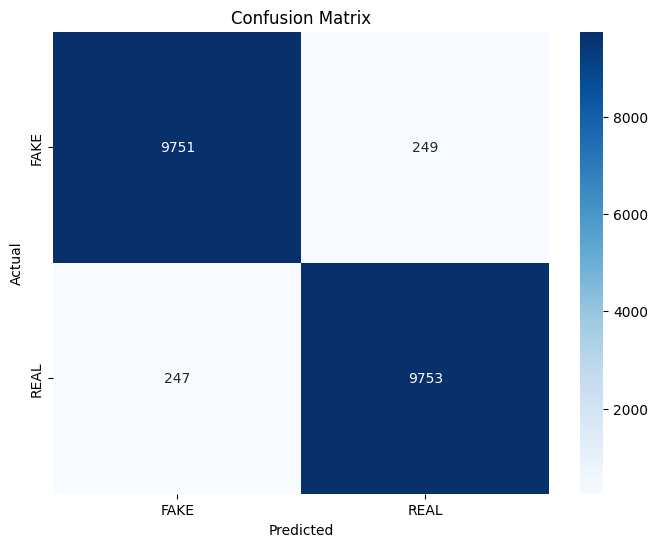

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.98      0.98      0.98     10000
        REAL       0.98      0.98      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load best model
model.load_state_dict(torch.load("best_resnet18_cifake.pth"))
model.eval()

# Predictions
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))


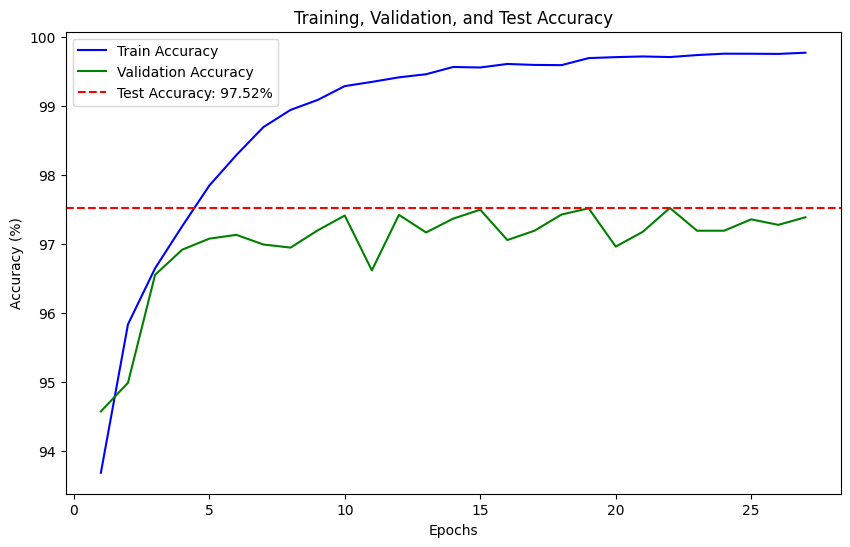

Final Test Accuracy: 97.52%


In [ ]:
# Plot training, validation, and test accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accs) + 1), train_accs, label="Train Accuracy", color='blue')
plt.plot(range(1, len(val_accs) + 1), val_accs, label="Validation Accuracy", color='green')

# Compute and plot test accuracy
test_accuracy = 100 * sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
plt.axhline(y=test_accuracy, color='red', linestyle='--', label=f"Test Accuracy: {test_accuracy:.2f}%")

plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training, Validation, and Test Accuracy")
plt.legend()
plt.show()

# Print test accuracy
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


In [ ]:
import torch

# Save the trained model
model_save_path = "best_resnet18_cifake.pth"
torch.save(model.state_dict(), model_save_path)

print(f"Model saved successfully at: {model_save_path}")


Model saved successfully at: best_resnet18_cifake.pth


In [ ]:
import pickle

# Prepare data dictionary
data_dict = {
    "train_classes": train_dataset.classes,
    "train_data": train_dataset.samples,
    "test_data": test_dataset.samples
}

# Save as .pkl file
pkl_filename = "cifake_dataset.pkl"
with open(pkl_filename, "wb") as pkl_file:
    pickle.dump(data_dict, pkl_file)

print(f"Dataset metadata saved as: {pkl_filename}")


Dataset metadata saved as: cifake_dataset.pkl


In [ ]:
# Load best model
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Compute final test accuracy
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_test_accuracy = 100 * correct / total
print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")


<ipython-input-12-2b531bcac5c2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Final Test Accuracy: 97.52%


In [ ]:
from google.colab import files

# Download the dataset pkl file
files.download("cifake_dataset.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>